In [88]:
import pandas as pd
# metadata 
# print(statlog_german_credit_data.metadata) 
# Show all columns
pd.set_option('display.max_columns', None)

# variable information 
vars_df = pd.read_csv('Dataset/processed_credit.csv')

# Open a saved Bayesian network

In [89]:
import os
import pyagrum as gum

bn_directory = "BNs"
id_directory = "ID_new"
networks = {}
influence_diagrams = {}

for filename in os.listdir(bn_directory):
    filepath = os.path.join(bn_directory, filename)
    if os.path.isfile(filepath):
        networks[filename] = gum.loadBN(filepath)

for filename in os.listdir(id_directory):
    filepath = os.path.join(id_directory, filename)
    if os.path.isfile(filepath):
        influence_diagrams[filename] = gum.loadID(filepath)

# Compare Networks with unobserved random variables
Already trained using various criterion but want to see performance given random subset of observed random variables in each sample
	-Take a random subset of variables to be observed for each sample and get the total expected utility

In [90]:
def inspect_var_ranges(infdiag, df=None, sample_rows=5):
    """Print labels for each variable in the influence diagram and sample uniques from df."""
    # print("Influence diagram variables and labels:")
    mismatches = []
    for var in infdiag.names():
        try:
            variable = infdiag.variable(var)
            try:
                labels = list(variable.labels())
            except Exception:
                # fall back to older API
                labels = [str(variable.label(i)) for i in range(variable.domainSize())]
            # print(f" - {var}: labels={labels}")
            uniques = df[var].dropna().unique()[:20]
            # print(f" - {var}: sample_uniques={list(map(str, uniques))}\n")
            if set(labels) != set(uniques):
                mismatches.append(var)
        except Exception as e:
            pass

    if mismatches:
        return mismatches
    else:
        print("All variable labels match the dataset.")
        return None
mismatches = []
for key, infdiag in influence_diagrams.items():
    # print(f"\nInspecting variable ranges for influence diagram: {key}")
    mismatches.extend(inspect_var_ranges(infdiag, df=vars_df))

Mapping from dataframe values to random variable values

In [91]:
print("\nVariables with mismatched labels:")
# Filter only unique mismatches
mismatches = list(set(mismatches))

# Create mapping from dataset values to BN labels
value_to_label = {
    (var, val): label
    for var in mismatches
    for val, label in zip(sorted(vars_df[var].unique()), sorted(infdiag.variable(var).labels()))
}

# Map dataset values to BN labels in vars_df
for var in mismatches:
    # Convert column to string/object type to avoid dtype issues
    vars_df[var] = vars_df[var].astype(str)

for (var, val), label in value_to_label.items():
    vars_df.loc[vars_df[var] == str(val), var] = str(label)

vars_df.head()


Variables with mismatched labels:


,CheckingAccount,Duration,CreditHistory,Purpose,CreditAmount,SavingsAccount,EmploymentSince,InstallmentRate,PersonalStatusSex,OtherDebtors,ResidenceSince,Property,Age,OtherInstallmentPlans,Housing,ExistingCredits,Job,LiablePeople,Telephone,ForeignWorker,CreditRisk
0,lt0,Short,Critical_account_other_credits_elsewhere,radio_television,Low,unknown_no_savings,ge7_years,4,male_single,none,4,real_estate,Old,none,own,2,skilled_employee_official,1,yes_registered_,yes,Good
1,No_Checking,Medium,Existing_credits_paid_duly_till_now,radio_television,Low,lt100_DM,_1to4_years,2,female_divorced_separated_married,none,2,real_estate,Young,none,own,1,skilled_employee_official,1,none,yes,Bad
2,_0to200,Short,Critical_account_other_credits_elsewhere,education,Low,lt100_DM,_4to7_years,2,male_single,none,3,real_estate,Middle,none,own,1,unskilled_resident,2,none,yes,Good
3,lt0,Medium,Existing_credits_paid_duly_till_now,furniture_equipment,Medium,lt100_DM,_4to7_years,2,male_single,guarantor,4,building_society_savings_life_insurance,Middle,none,for_free,1,skilled_employee_official,2,none,yes,Good
4,lt0,Short,Delay_in_paying_off_in_the_past,car_new_,Low,lt100_DM,_1to4_years,3,male_single,none,4,unknown_no_property,Middle,none,for_free,2,skilled_employee_official,2,none,yes,Bad


In [92]:
import random
from pyagrum import ShaferShenoyLIMIDInference
import numpy as np
import pyagrum.lib.notebook as gnb

def generate_evidence_sets(df, observed_fraction=0.6, seed=42):
    '''Pre-generate evidence sets for all samples to ensure fair comparison'''
    random.seed(seed)
    evidence_sets = []
    
    for idx, row in df.iterrows():
        vars_list = row.index.tolist()
        if 'CreditRisk' in vars_list:
            vars_list.remove('CreditRisk')
        
        num_vars = len(vars_list)
        num_observed = max(1, int(num_vars * observed_fraction))
        observed_vars = random.sample(vars_list, num_observed)
        evidence = {var: row[var] for var in observed_vars}
        evidence_sets.append(evidence)
    
    return evidence_sets

def getInfluenceExpectedUtility(idx, ie, evidence:dict, infdiag):
	'''Given an influence diagram and evidence, compute the expected utility'''
	if evidence:
		for var, value in evidence.items():
			try:
				variable = infdiag.variable(var)
				idx_val = variable.index(str(value))
				ie.addEvidence(var, idx_val)
			except gum.GumException as e:
				print(f"Could not set evidence for {var}={value}. Error: {e}")

	ie.makeInference()
	
	# Get expected utilities for each action
	expected_utility_tensor = ie.posteriorUtility('ApproveLoan')
	eu_approve = expected_utility_tensor[0]
	eu_reject = expected_utility_tensor[1]
    
    # Choose optimal action based on expected utility
	if eu_approve >= eu_reject:
		optimal_decision = 'Approve'
	else:
		optimal_decision = 'Reject'
    
    # Get actual CreditRisk from dataset
	actual_credit_risk = vars_df.loc[idx, 'CreditRisk']
    
	# util["Good", "Approve"] = 0     
    # util["Bad", "Approve"] = -5     
    # util["Good", "Reject"] = -1     
    # util["Bad", "Reject"] = 0 
    # Calculate REALIZED utility based on actual outcome
	realised_utility = 0
	if optimal_decision == 'Approve' and actual_credit_risk == 'Bad':
		realised_utility = -5
	elif optimal_decision == 'Reject' and actual_credit_risk == 'Good':
		realised_utility = -1
	
	ie.eraseAllEvidence()

	return realised_utility

# Pre-generate evidence sets ONCE
print("Generating evidence sets...")
evidence_sets = []
RANDOM_SEEDS = [42, 7, 21, 84, 100]
for s in RANDOM_SEEDS:
	evidence_sets.append(generate_evidence_sets(vars_df, observed_fraction=0.6, seed=s))

print(f"Generated {len(evidence_sets)} evidence sets")

# Evaluate all networks using the SAME evidence
evaluation_results = {}

for key, value in influence_diagrams.items():
	total_utility = 0.0
	infdiag = value
	ie = ShaferShenoyLIMIDInference(infdiag)

	# Show inference diagram structure
    # print(f"\nEvaluating influence diagram: {key}")
    # gnb.showInference(infdiag, engine = ie)

    # Use pre-generated evidence sets
	for e in evidence_sets:
		for idx, evidence in enumerate(e):
			# print(f"Evaluating sample {idx+1}/{len(e)} with evidence: {evidence}")
			# Compute expected utility and get realised utility	
			realised_utility = getInfluenceExpectedUtility(idx, ie, evidence, infdiag)
			total_utility += realised_utility

	evaluation_results[key] = total_utility

print(evaluation_results)

best_model = max(evaluation_results, key=evaluation_results.get)
inf = influence_diagrams[best_model]
best_utility = evaluation_results[best_model]
print(f"Best model: {best_model} with total utility: {best_utility}")

Generating evidence sets...
Generated 5 evidence sets
{'credit_decision_influence_diagram_bn.xml': -5583.0, 'credit_decision_influence_diagram_cl.xml': -5024.0, 'credit_decision_influence_diagram_ghc.xml': -4784.0, 'credit_decision_influence_diagram_tb.xml': -6795.0}
Best model: credit_decision_influence_diagram_ghc.xml with total utility: -4784.0


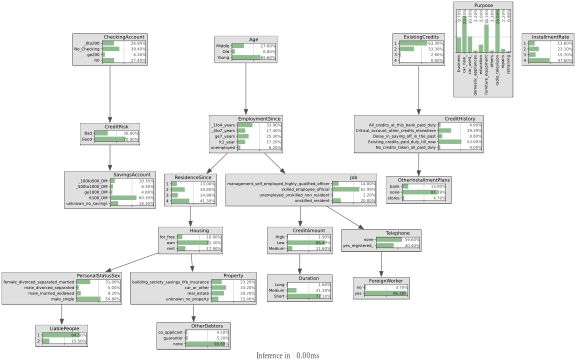

In [97]:
filepath = 'BNs/credit_risk_ghc.bif'
bn = gum.loadBN(filepath)
gnb.showInference(bn)

# Inference for unobserved variables

Given that we have no evidence, based on prior probabilities, what is the probability of a given applicant being a good credit risk?

Given status of existing checking account: what is the new posterior credit Risk
If the status of the existing checking account (debit) was >= 200 Deutsche Mark, the chance that this was good credit was 7.77% higher

German currency 1994: Deutsche Mark

Now, for a checking account with < 0 Deutsche Mark (DM)

What about if an applicant had no checking account:

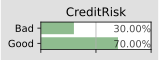

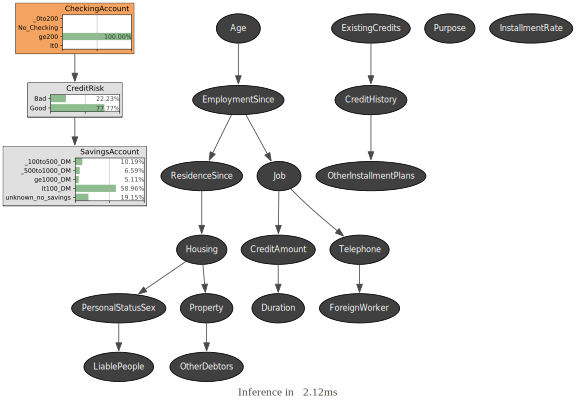

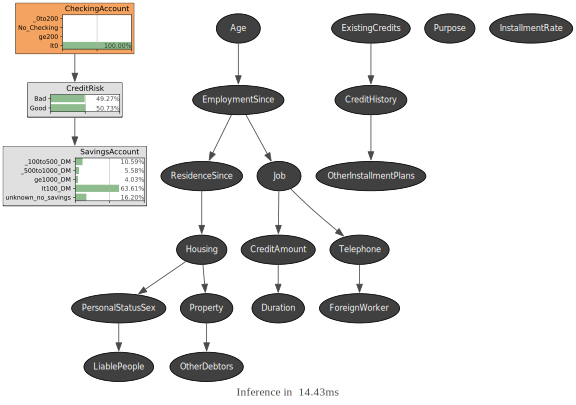

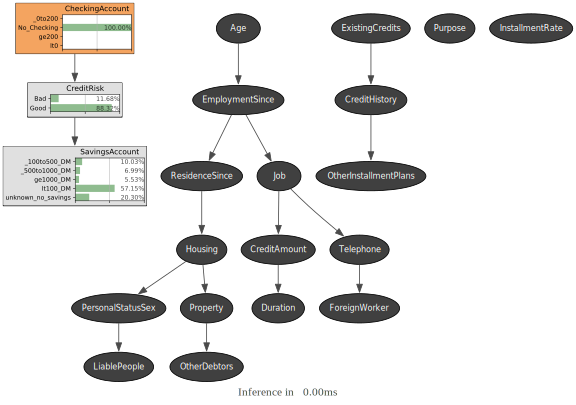

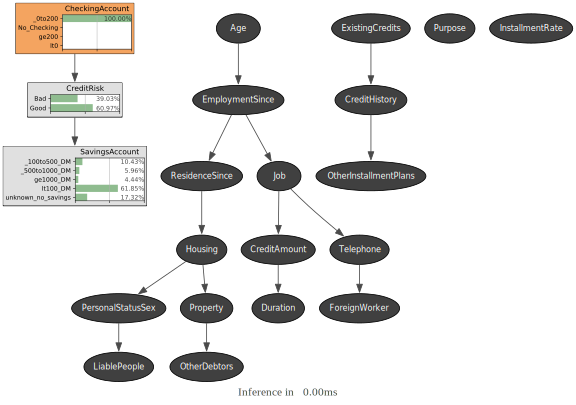

In [94]:
gnb.showPosterior(bn, evs={}, target="CreditRisk")
gnb.showInference(bn, evs={"CheckingAccount": "ge200"}, targets={"CreditRisk", "CheckingAccount", "SavingsAccount"})
gnb.showInference(bn, evs={"CheckingAccount": "lt0"}, targets={"CreditRisk", "CheckingAccount", "SavingsAccount"})
gnb.showInference(bn, evs={"CheckingAccount": "No_Checking"}, targets={"CreditRisk", "CheckingAccount", "SavingsAccount"})
gnb.showInference(bn, evs={"CheckingAccount": "_0to200"}, targets={"CreditRisk", "CheckingAccount", "SavingsAccount"})

Applicants had the best perceived credit risk when they had no checking account

Now, given perceived credit risk, what was the most likely status of the applicants savings account?

For Good perceived credit risk: applicants would most likely have less than 100 DM in their savings account.

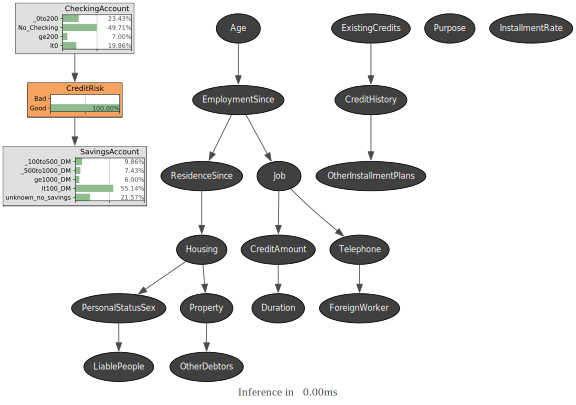

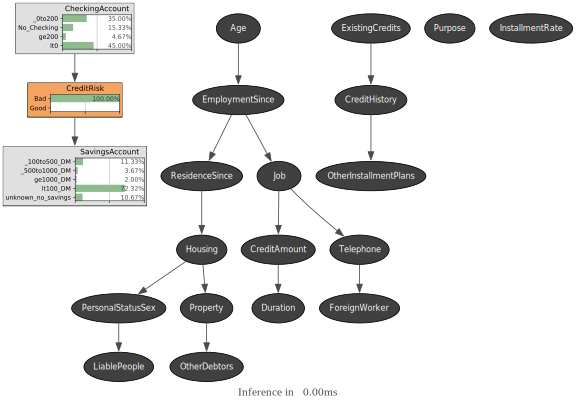

In [95]:
gnb.showInference(bn, evs={"CreditRisk": "Good"}, targets={"CreditRisk", "CheckingAccount", "SavingsAccount"})
gnb.showInference(bn, evs={"CreditRisk": "Bad"}, targets={"CreditRisk", "CheckingAccount", "SavingsAccount"})

Given bad perceived credit risk, there was a higher chance of an applicant having less than 100 DM in their savings account.

With the lowest probability assigned to having greater than 1000 DM in their savings account.

# Age subnetwork

